<a href="https://colab.research.google.com/github/hs0224/Capstone-Design/blob/main/fall_notfallen_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 딥러닝 분류 모델 만들기
- Fall Object Detection 하기 앞서 Fall, 그리고 not Fallen인 이미지를 분류하는 모델을 먼저 만들어 봄

- Object Detection 은 기본적으로 두가지 문제가 있음  
  1. Bounding box의 좌표값 예측 문제
  1. 해당 영역에 대한 분류문제

> 우리는 먼저 2번에 해당하는 분류문제를 이해하기 위해 Fall, not Fallen 이미지를 통해 분류 모델을 만들어봄

In [1]:
from fastai.vision.all import *

In [2]:
!mkdir /content/data # train 데이터를 저장할 폴더 생성

In [ ]:
!unzip /content/data/train.zip -d /content/data/
# 로컬에서 mydrive로 zip파일로 된 train 데이터를 옮겨줌

In [4]:
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

file_path = '/content/data/train/' # 이미지 파일이 저장된 폴더
fall_images = os.listdir(file_path+'fall') # fall 이미지 폴더
notfall_images = os.listdir(file_path+'notfallen') # not fallen 이미지 폴더

In [7]:
# 이미지 파일 시각화
def show_images(file_path, file_name, ncols=8):
  figure, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)

  for i in range(ncols):
    scr = os.path.join(file_path, file_name[i])
    img = cv2.imread(scr)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    dst = cv2.resize(img_rgb, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    axs[i].imshow(dst)
    axs[i].set_title(file_name[i][:-7])

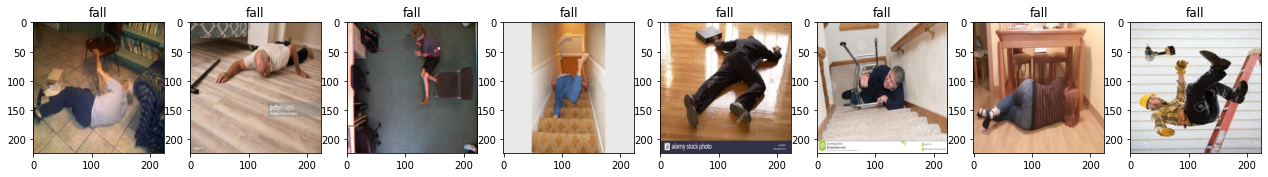

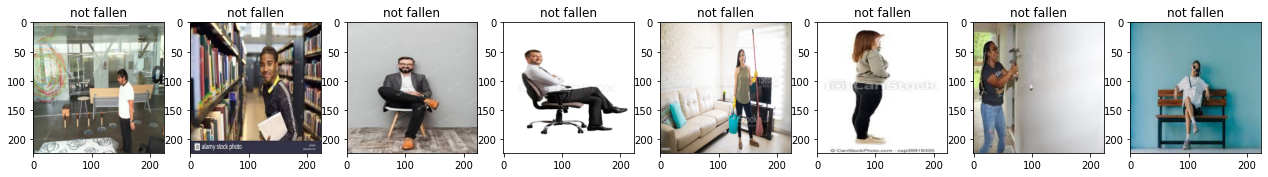

In [8]:
# 각각 이미지 8장씩 확인
show_images(file_path+'fall', fall_images[:8])
show_images(file_path+'notfallen', notfall_images[:8])

In [10]:
# path 객체 생성(각각 이미지별로)
path = Path(file_path)
fns = get_image_files(path)
get_image_files(path)

(#485) [Path('/content/data/train/fall/fall248.jpg'),Path('/content/data/train/fall/fall092.jpg'),Path('/content/data/train/fall/fall190.jpg'),Path('/content/data/train/fall/fall246.jpg'),Path('/content/data/train/fall/fall238.jpg'),Path('/content/data/train/fall/fall077.jpg'),Path('/content/data/train/fall/fall274.jpg'),Path('/content/data/train/fall/fall228.jpg'),Path('/content/data/train/fall/fall046.jpg'),Path('/content/data/train/fall/fall023.jpg')...]

## 데이터에서 DataFoaders까지

In [11]:
# 전달받은 여러 DataLoader 객체를 목적에 맞게 학습용과 검증용으로 나누어 저장하는 클래스
class DataLoaders(GetAttr):
    def __init__(self, *loaders):
      self.loaders = loaders

    def __getitem__(self, i):
      return self.loaders[i]
    
    train, valid = add_props(lambda i, self:self[i])

In [12]:
state = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(valid_pct=0.2, seed=42),
                  get_y = parent_label,
                  item_tfms=Resize(128))

In [ ]:
# 여기서는 각각 이미지별로 폴더가 구별되 있음
for i in get_image_files(path):
  print(Path(i).parent.name)

In [15]:
dls = state.dataloaders(path)

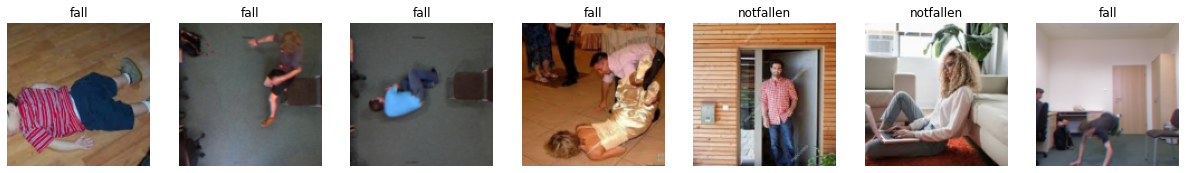

In [16]:
# 하나의 배치의 요소 중 일부를 화면에 보여줌
dls.valid.show_batch(max_n=7, nrows=1)

**잘라내는 과정에서 이미지의 중요한 세부사항이 유실되는 결과가 초래될 수 있음**
- 잘라내는 대신 이미지를 찌그러뜨리는 방법
- 너비나 높이 중 더 큰쪽으로 기준으로 크기를 맞춘 다음, 빈 곳을 0(검은색)으로 채우거나 이미지를 늘어뜨려 채우는 방법이 있음


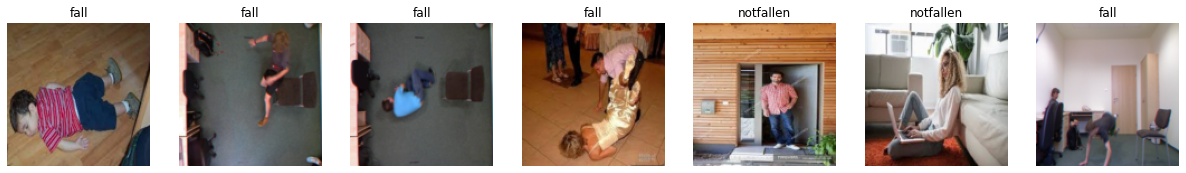

In [18]:
state = state.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = state.dataloaders(path)
dls.valid.show_batch(max_n=7, nrows=1)

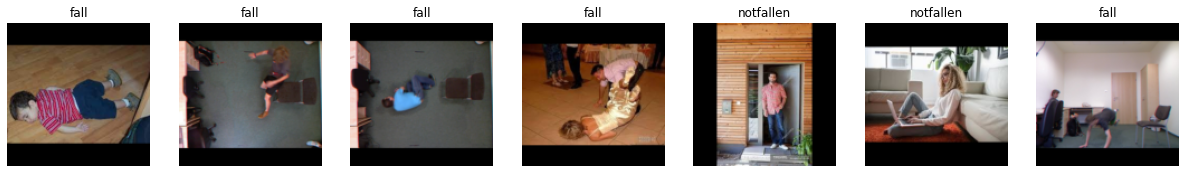

In [19]:
state = state.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = state.dataloaders(path)
dls.valid.show_batch(max_n=7, nrows=1)

**위치와 크기가 약간씩 다른 이미지로 모델을 학습시키면, 그 이미지에 포함된 물체의 기본 개념과 표현된 방식을 이해하는데 도움이 될 것임**

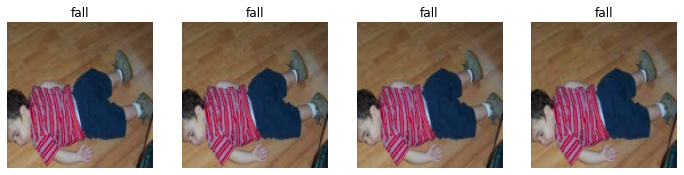

In [20]:
state = state.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
# min_scale : 얼마나 많은 영역을 선택할지 결정
dls = state.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)
# unique : 이미지에 반복해서 적용되는 RandomResizedCrop 변형이 만드는 서로 다른 이미지를 확인할 수 있음

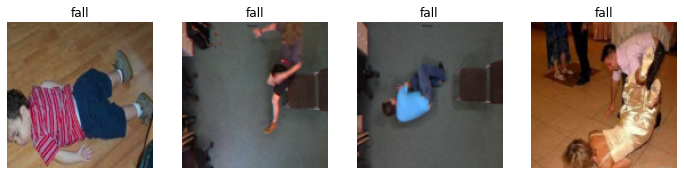

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

**데이터 증강**
- 입력 데이터를 임의로 변형해 새로운 데이터를 생성하는 기법
- 변형된 결과들은 서로 다른 개체를 만들지만, 데이터 자체의 의미를 바꿔서는 안됨
> 회전, 뒤집기, 원근 뒤틀기, 명도 바꾸기, 채도 바꾸기 등이 있음


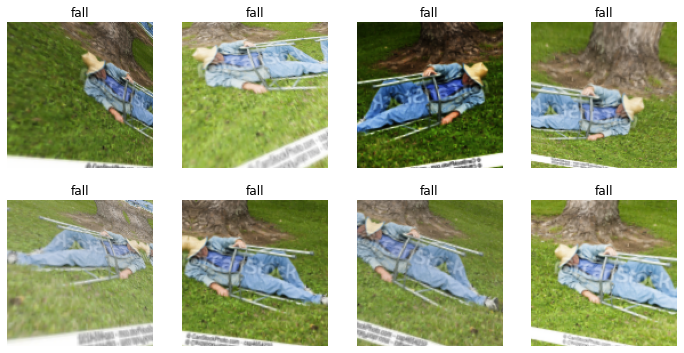

In [22]:
state = state.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
# aug_transforms : 표준적인 데이터 증강 목록 적용 
dls = state.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## 모델 훈련과 훈련된 모델을 이용한 데이터 정리

In [33]:
state = state.new(item_tfms=RandomResizedCrop(224, min_scale=0.3),
                  batch_tfms=aug_transforms())
dls = state.dataloaders(path)

In [34]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

**어디서 주로 실수를 했는지 오차 행렬을 통해 알아봄**

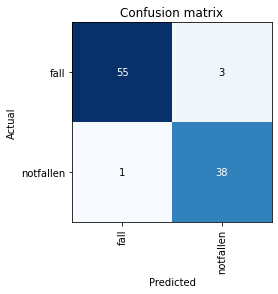

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

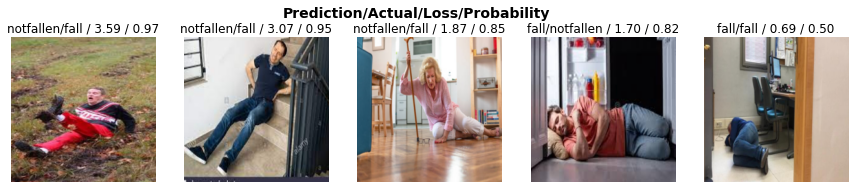

In [36]:
interp.plot_top_losses(5, nrows=1)
# 가장 손실이 높은 이미지를 보여줌
# 예측된 범주/실제 범주(타깃 레이블)/손실/확률 정보

In [37]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

- ipynb에서 GUI로 간단히 데이터를 정리할 수 있는 클래스를 제공
> 범주별, 학습/검증용 데이터셋별로 가장 손실이 큰 순서대로 정렬된 이미지를 확인할 수 있다.  
> 또한 출력된 이미지를 선택하여 삭제하거나 다시 레이블링할 수도 있다.
- ImageClassifierCleaner가 이미지를 실제로 삭제하거나 레이블을 변경하지 않는다. 직접 삭제 또는 변경 목록의 색인번호를 반환한 것으로 가지고 추가 작업이 필요하다

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# 삭제를 선택한 모든 이미지를 실제로 삭제(unlink)하는 코드

In [ ]:
import shutil

for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
# 레이블의 변경을 선택한 모든 이미지를 알맞은 범주의 디렉터리로 옮기는 코드

## 모델을 온라인 애플리케이션으로 전환하기

- 만족스러운 모델을 배포환경에서 사용하려면 우선 파일 형태로 서버에 저장해야함
> 모델은 **구조**와 **학습된 파라미터**로 두 부분으로 구성됨
- 여기서는 export 메서드로 모델의 구조와 파라미터를 모두 파일로 쉽게 저장할 수 있음 (사실 DataLoaders 생성 방법의 정의까지 저장함)
> 그렇지 않으면 데이터의 변형 방법을 다시 정의해야하기 때문

In [38]:
learn.export() # /content/export.pkl

In [39]:
# 해당 파일이 잘 생성되었는지 확인
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

**모델을 학습 대신 예측에 사용하는 것을 추론이라고 함**
- 추론에 모델 사용해보기

In [40]:
# 파일로 저장된 모델로 추론형 Learner객체 생성
learn_inf = load_learner(path/'export.pkl')

In [43]:
learn_inf.predict('/content/data/fall.jpg')
# 예측된 범주(문자열), 예측된 범주의 색인 번호, 확률
# fall or not fallen중 임의의 사진을 해당경로에 로드 

('fall', TensorBase(0), TensorBase([9.9959e-01, 4.0605e-04]))

In [45]:
learn_inf.dls.vocab # Learner의 dls 속성을 활용해서 실제 DataLoaders에도 접근 가능
# 어떤 정보를 분류했는지 나옴

['fall', 'notfallen']

In [47]:
learn_inf.dls.vocab[0] # 예측된 범주의 색인 번호로 해당 값을 얻을 수 있음
# 어떤값으로 예측했는지 나옴 위에선 Tensorbase(0) -> 0번째로 예측함

'fall'

## 모델로 노트북 애플리케이션 만들기
- 주피터 노트북으로 웹 애플리케이션 만들기
> IPython 위젯(ipywidgets) : 자바스크립트와 파이썬을 함께 묶어 웹 브라우저상에서 파이썬을 사용할 수 있도록 만들어주는 GUI 구성 요소 
  - 단점 : 사용자가 직접 주피터 노트북을 실행해야함 

  > Voila : IPython 위젯의 단점 보완 
    - 주피터 노트북에 내재된 내용을 배포하기 쉬운 웹 애플리케이션 형태로 변환
    - 주피터 노트북을 사용하는 개발 환경의 이점도 함께 누릴 수 있음
    

In [57]:
import ipywidgets as widgets
btn_upload = widgets.FileUpload()
btn_upload # 아무거나 구글에서 다운받아서 업로드함

FileUpload(value={}, description='Upload')

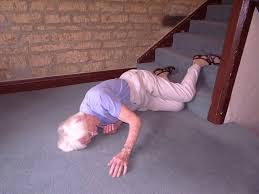

In [59]:
from PIL import Image
img = PILImage.create(btn_upload.data[-1])
img

In [60]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:display(img.to_thumb(128, 128)) # 우리가 모델을 학습할떄 사용했던 이미지크기랑 동일하게 맞춰줌
out_pl

Output()

In [61]:
pred, pred_idx, probs = learn_inf.predict(img)
print(pred) # 예측된 범주(문자열)
print(pred_idx) # 예측된 범주의 색인 번호
print(probs)# 확률

fall
TensorBase(0)
TensorBase([1.0000e+00, 6.6961e-07])


In [62]:
lbl_pred = widgets.Label() # Label 위젯을 사용해서 예측 결과를 화면에 출력
lbl_pred.value = f'Prediction:{pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction:fall; Probability: 1.0000')

In [63]:
# 이미지 분류를 요청하는 버튼 생성
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [64]:
# 클릭 이벤트 핸들로 생성 (위에서 작성했던걸 합침)
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128, 128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [66]:
VBox([widgets.Label('fall classifier'),
      btn_upload, btn_run, out_pl, lbl_pred])